In [17]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import numpy as np
from PIL import Image

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

import ssl

import matplotlib.pyplot as plt

In [2]:
os.chdir("..")
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
PATCH_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
N_EPOCHS = 30
N_WORKERS = 10
MODELS_PATH = "models/classification"
TARGET_NAMES = ["Normal", "COVID", "Lung_Opacity", "Viral_Pneumonia"]
N_CLASSES = len(TARGET_NAMES)

In [4]:
class Covid19Dataset(Dataset):
    def __init__(self, image_paths, labels):
        """
        image_paths: Lista de caminhos das imagens.
        labels: Lista das respectivas classes das imagens.
        """
        self.image_paths = image_paths
        self.labels = labels
        # Default transform
        self.transform = transforms.Compose(
            [
                transforms.Resize(PATCH_SIZE),
                transforms.ToTensor(),
            ]
        )


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Carrega a imagem
        image = Image.open(img_path).convert("RGB")

        image = self.transform(image)

        return image, label
    
    def set_transform(self, transform):
        self.transform = transform


In [5]:
from sklearn.model_selection import train_test_split

data_dir = "data/raw"

all_image_paths = []
all_labels = []

for i, class_name in enumerate(TARGET_NAMES):
    class_dir = os.path.join(data_dir, class_name)
    images_dir = os.path.join(class_dir, "images")
    images_names = sorted(os.listdir(images_dir))

    for img_name in images_names[:250]:
        img_path = os.path.join(images_dir, img_name)
        all_image_paths.append(img_path)
        all_labels.append(i)

train_images, test_images, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42
)

In [6]:
train_dataset = Covid19Dataset(train_images, train_labels)
test_dataset = Covid19Dataset(test_images, test_labels)

In [7]:
def train_model(model, train_loader, criterion, optimizer, n_epochs):
    model.train() 

    start_time = time.time()
    for epoch in range(n_epochs):        
        running_loss = 0.0
        running_corrects = 0
        
        # Treinamento
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Epoch {epoch+1}/{n_epochs} / Loss: {epoch_loss:.4f} / Acc: {epoch_acc:.4f}")
        print('-' * 40)
    
    elapsed_time = time.time() - start_time
    print(f"Tempo de treino: {elapsed_time:.2f} segundos")


In [8]:
def evaluate_model(model, test_loader, target_names):
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calcular tempo de execução
    elapsed_time = time.time() - start_time
    print(f"Tempo de teste: {elapsed_time:.2f} segundos")

    # Calcular métricas globais
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    global_f1 = f1_score(all_labels, all_preds, average="weighted")
    global_acc = accuracy_score(all_labels, all_preds)

    print(f"Global F1-score: {global_f1:.4f}")
    print(f"Global Accuracy: {global_acc:.4f}")

    # F1-score por classe
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    print(f"F1-score por classe: {f1_per_class}")

    # Preparando os gráficos

    num_classes = len(target_names)

    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

    # Figura para a matriz de confusão
    plt.figure(figsize=(10, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Matriz de Confusão', fontdict={"fontweight": "bold"})
    plt.xlabel('Real', fontdict={"fontweight": "bold"})
    plt.ylabel('Predito', fontdict={"fontweight": "bold"})
    plt.xticks(rotation=45)
    plt.show()

    # Curvas ROC e AUC por classe
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))  # Binarizar labels
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(8, 6))  # Figura separada para as curvas ROC
    for i, target_name in enumerate(target_names):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{target_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo', fontdict={"fontweight": "bold"})
    plt.ylabel('Verdadeiro Positivo', fontdict={"fontweight": "bold"})
    plt.title('Curva ROC Multiclasse', fontdict={"fontweight": "bold"})
    plt.legend(loc='lower right')
    plt.show()


In [9]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [10]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))

Tempo de teste: 2.91 segundos
Global F1-score: 0.2222
Global Accuracy: 0.3400
F1-score por classe: [0.         0.         0.36697248 0.49484536]


<Figure size 1000x600 with 0 Axes>

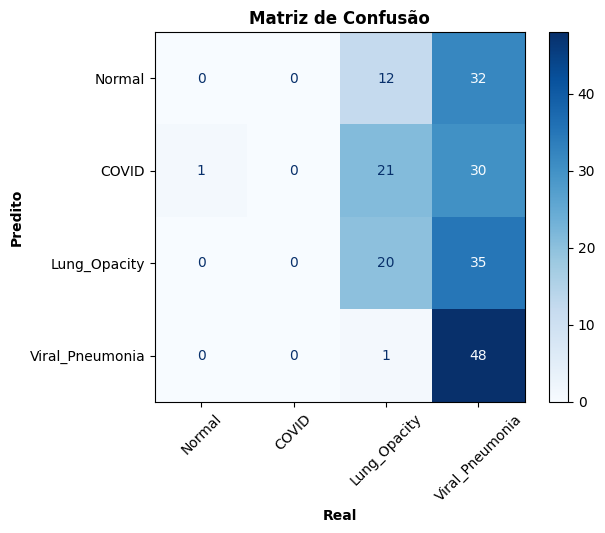

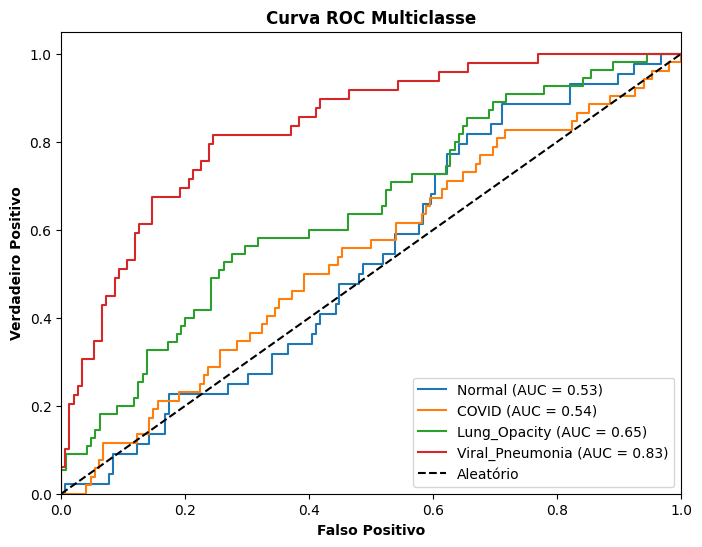

In [18]:
xception_pretrained = timm.create_model("xception", pretrained=True)
xception_pretrained.fc = nn.Linear(xception_pretrained.fc.in_features, N_CLASSES)
xception_pretrained = xception_pretrained.to(DEVICE)

config = resolve_data_config({}, model=xception_pretrained)
transform = create_transform(**config)
test_dataset.set_transform(transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory = True,
    shuffle=False,
    drop_last=False,
    num_workers=N_WORKERS
)

evaluate_model(xception_pretrained, test_loader, TARGET_NAMES)

In [20]:
xception_tl = timm.create_model("xception", pretrained=True)
for param in xception_tl.parameters():
    param.requires_grad = False
xception_tl.fc = nn.Linear(xception_tl.fc.in_features, N_CLASSES)
for param in xception_tl.fc.parameters():
    param.requires_grad = True
xception_tl = xception_tl.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_tl.fc.parameters(), lr=0.001)

model_path = os.path.join(MODELS_PATH, "xception_tl.pth")
if os.path.exists(model_path):
    load_model(xception_tl, model_path)
    print("Modelo carregado!")
else:
    train_dataset.set_transform(transform)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        pin_memory = True,
        shuffle=True,
        drop_last=False,
        num_workers=N_WORKERS
    )

    train_model(xception_tl, train_loader, loss_fn, optimizer, N_EPOCHS)
    save_model(xception_tl, model_path)
    print("Modelo treinado!")

/home/davi/projects/TI0160-visao-computacional/venv/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/30 / Loss: 1.0989 / Acc: 0.5713
----------------------------------------
Epoch 2/30 / Loss: 0.7526 / Acc: 0.7800
----------------------------------------
Epoch 3/30 / Loss: 0.6640 / Acc: 0.7712
----------------------------------------
Epoch 4/30 / Loss: 0.5825 / Acc: 0.8087
----------------------------------------
Epoch 5/30 / Loss: 0.5249 / Acc: 0.8325
----------------------------------------
Epoch 6/30 / Loss: 0.4799 / Acc: 0.8662
----------------------------------------
Epoch 7/30 / Loss: 0.4651 / Acc: 0.8638
----------------------------------------
Epoch 8/30 / Loss: 0.4713 / Acc: 0.8550
----------------------------------------
Epoch 9/30 / Loss: 0.4170 / Acc: 0.8762
----------------------------------------
Epoch 10/30 / Loss: 0.4079 / Acc: 0.8712
----------------------------------------
Epoch 11/30 / Loss: 0.4122 / Acc: 0.8575
----------------------------------------
Epoch 12/30 / Loss: 0.3619 / Acc: 0.8962
----------------------------------------
Epoch 13/30 / Loss: 0.344

Tempo de teste: 1.98 segundos
Global F1-score: 0.8484
Global Accuracy: 0.8500
F1-score por classe: [0.83333333 0.84955752 0.76923077 0.94949495]


<Figure size 1000x600 with 0 Axes>

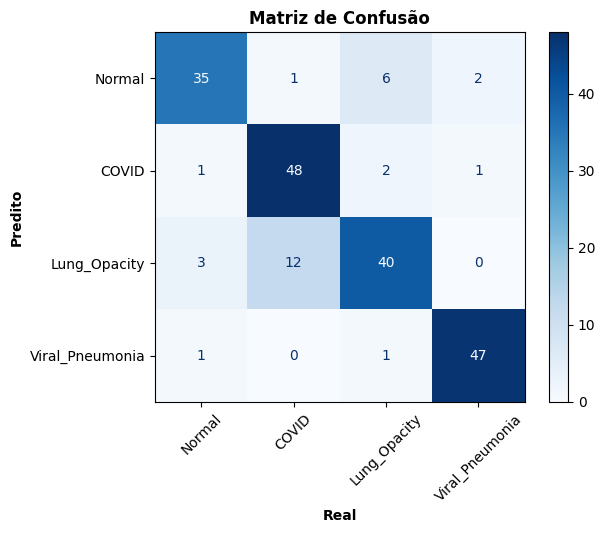

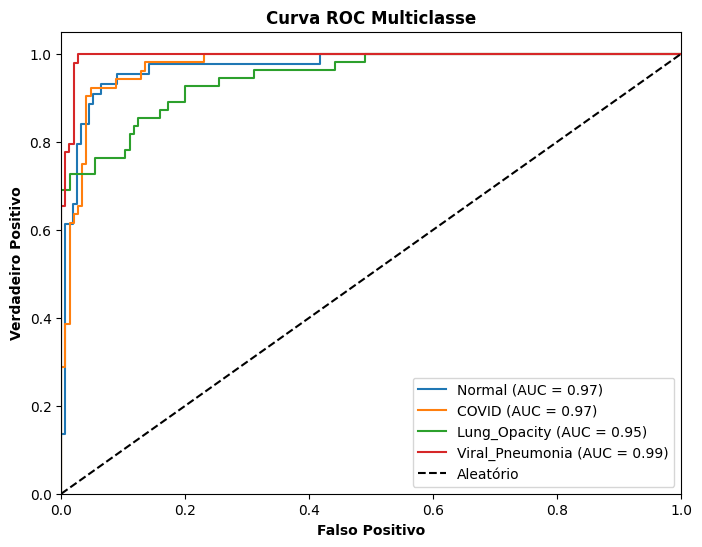

In [21]:
test_dataset.set_transform(transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory = True,
    shuffle=False,
    drop_last=False,
    num_workers=N_WORKERS
)

evaluate_model(xception_tl, test_loader, TARGET_NAMES)